<h2><b> Importing Dataset and Libraries

In [1]:
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Total 29924 (delta 0), reused 0 (delta 0), pack-reused 29924 (from 1)
Receiving objects: 100% (29924/29924), 3.93 GiB | 34.25 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (24399/24399), done.


In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import soundfile as sf
import IPython.display as ipd

<h2><b> Converting to Spectogram

In [3]:
base_dir='MS-SNSD/'
noisy_folder = os.path.join(base_dir, 'NoisySpeech_training')
clean_folder = os.path.join(base_dir, 'CleanSpeech_training')

Inspecting file: noisy396_SNRdb_10.0_clnsp396.wav


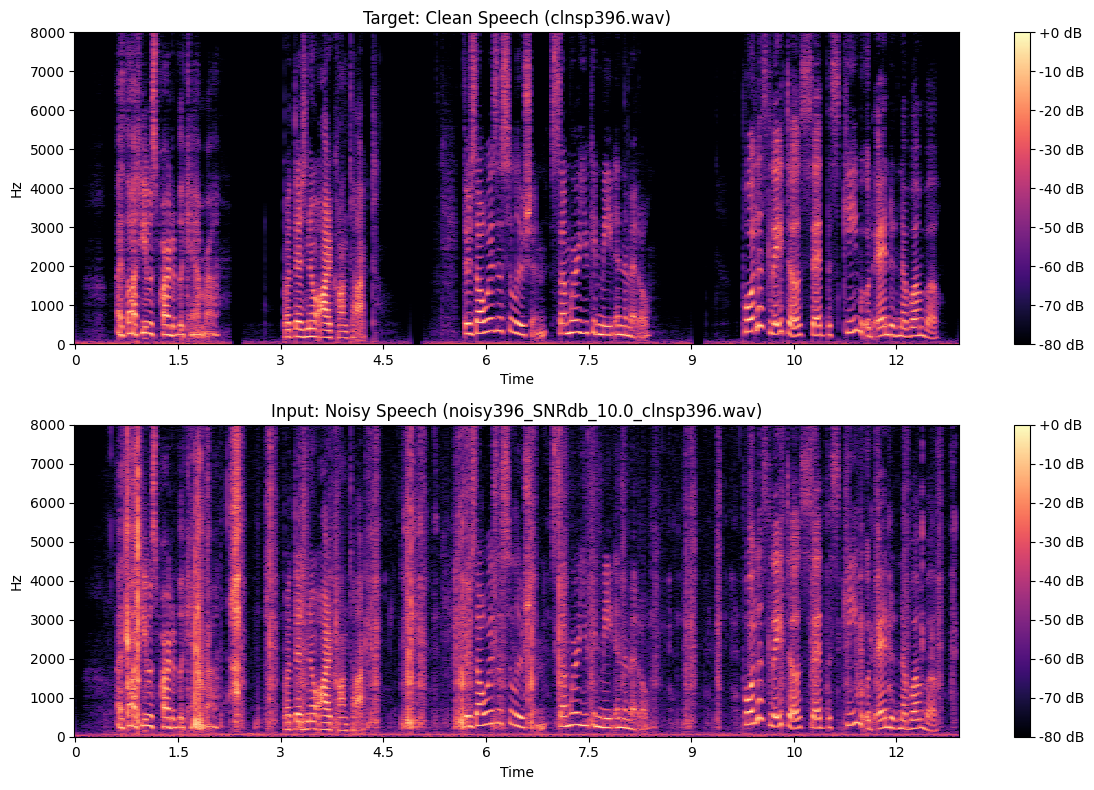

In [4]:
files = os.listdir(noisy_folder)
wav_files = [f for f in files if f.endswith('.wav')]

if not wav_files:
    print("Error: No .wav files found in NoisySpeech_training!")
else:
    filename = wav_files[0]
    print(f"Inspecting file: {filename}")

    noisy_path = os.path.join(noisy_folder, filename)

    file_id = filename.split('_')[-1]
    clean_path = os.path.join(clean_folder, file_id)

    if not os.path.exists(clean_path):
        print(f"Note: Exact match {file_id} not found. Using first available clean file.")
        clean_path = os.path.join(clean_folder, [f for f in os.listdir(clean_folder) if f.endswith('.wav')][0])

    noisy_audio, sr = librosa.load(noisy_path, sr=16000)
    clean_audio, _ = librosa.load(clean_path, sr=16000)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio)), ref=np.max)
    librosa.display.specshow(D_clean, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Target: Clean Speech ({os.path.basename(clean_path)})')

    plt.subplot(2, 1, 2)
    D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_audio)), ref=np.max)
    librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Input: Noisy Speech ({filename})')

    plt.tight_layout()
    plt.show()

<h2><b> Data Pre-Processing

In [5]:
SAMPLE_RATE = 16000
DURATION = 1.0
N_FFT = 255
HOP_LEN = 125

In [6]:
NOISY_DIR = os.path.join(base_dir, 'NoisySpeech_training')
CLEAN_DIR = os.path.join(base_dir, 'CleanSpeech_training')

In [7]:
def process_audio_data():
    x_data = []
    y_data = []

    print("Processing audio files...")

    noisy_files = [f for f in os.listdir(NOISY_DIR) if f.endswith('.wav')]

    for f in noisy_files:
        noisy_path = os.path.join(NOISY_DIR, f)
        audio_n, _ = librosa.load(noisy_path, sr=SAMPLE_RATE)

        clean_filename = f.split('_')[-1]
        clean_path = os.path.join(CLEAN_DIR, clean_filename)

        if not os.path.exists(clean_path):
            continue

        audio_c, _ = librosa.load(clean_path, sr=SAMPLE_RATE)

        samples_per_segment = int(SAMPLE_RATE * DURATION)
        num_segments = len(audio_n) // samples_per_segment

        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment

            seg_n = audio_n[start:end]
            seg_c = audio_c[start:end]

            spec_n = librosa.stft(seg_n, n_fft=N_FFT, hop_length=HOP_LEN)
            spec_c = librosa.stft(seg_c, n_fft=N_FFT, hop_length=HOP_LEN)

            mag_n = np.log1p(np.abs(spec_n))
            mag_c = np.log1p(np.abs(spec_c))

            x_data.append(mag_n.T)
            y_data.append(mag_c.T)

    X = np.array(x_data)
    Y = np.array(y_data)

    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]

    return X, Y

In [8]:
X_train, Y_train = process_audio_data()

print("Data Processing Complete!")
print(f"Input Shape: {X_train.shape}")
print(f"Target Shape: {Y_train.shape}")

Processing audio files...
Data Processing Complete!
Input Shape: (17235, 128, 128, 1)
Target Shape: (17235, 128, 128, 1)


<h2><b> Building the AI

In [9]:
def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)


    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c2])
    c4 = Conv2D(64, (3, 3), padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c1])
    c5 = Conv2D(32, (3, 3), padding='same')(u1)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(1, (1, 1), padding='same', activation='linear')(c5)

    model = Model(inputs, outputs)
    return model

input_shape = X_train.shape[1:]
model = build_unet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ activation_2[0][… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 232,321 (907.50 KB)

 Trainable params: 231,681 (905.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
# Safety Brake A: Stop if the model stops learning (prevents overfitting)
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Safety Brake B: Save the best model automatically
checkpointer = ModelCheckpoint(
    filepath='best_mrdnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 2. Train with the Brakes On ---
history = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopper, checkpointer]
)

model.save('mrdnn_final.keras')
print("Training Complete. Best model saved as 'best_mrdnn.keras'")

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0854
Epoch 1: val_loss improved from inf to 0.01502, saving model to best_mrdnn.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 61s 93ms/step - loss: 0.0852 - val_loss: 0.0150
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0094
Epoch 2: val_loss improved from 0.01502 to 0.00923, saving model to best_mrdnn.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 3/50
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0083
Epoch 3: val_loss improved from 0.00923 to 0.00739, saving model to best_mrdnn.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/50
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0076
Epoch 4: val_loss did not improve from 0.00739
485/485 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.0076 - val_loss: 0.0163
Epoch 5/50
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0073
Epoch 5: val_loss improved from 0.00739 to 0.00695, sa

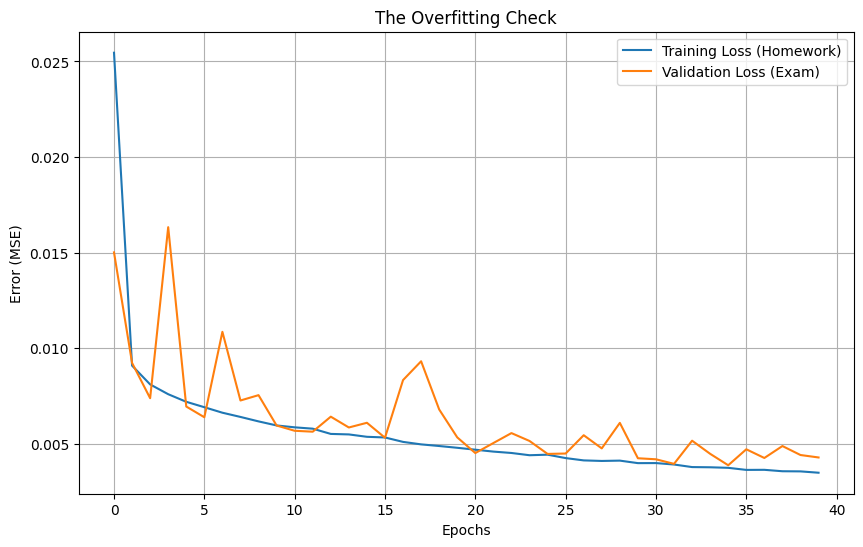

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (Homework)')
plt.plot(history.history['val_loss'], label='Validation Loss (Exam)')
plt.title('The Overfitting Check')
plt.xlabel('Epochs')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print("Loading the best model...")
model = tf.keras.models.load_model('best_mrdnn.keras')
noisy_folder = 'MS-SNSD/NoisySpeech_training'
test_filename = os.listdir(noisy_folder)[10]
noisy_path = os.path.join(noisy_folder, test_filename)

Loading the best model...


In [17]:
def clean_audio_with_phase(audio_path, model):
    audio, sr = librosa.load(audio_path, sr=16000)

    chunk_len = 128 * 125
    padding = chunk_len - (len(audio) % chunk_len)
    padded_audio = np.pad(audio, (0, padding))

    full_spec = librosa.stft(padded_audio, n_fft=255, hop_length=125)
    full_mag, full_phase = librosa.magphase(full_spec)

    num_chunks = full_mag.shape[1] // 128

    clean_mags = []

    for i in range(num_chunks):
        seg_mag = full_mag[:, i*128 : (i+1)*128]

        log_mag = np.log1p(seg_mag)

        input_chunk = log_mag.T[np.newaxis, ..., np.newaxis]

        pred = model.predict(input_chunk, verbose=0)

        clean_seg = np.expm1(pred.squeeze().T)
        clean_mags.append(clean_seg)

    clean_mag_full = np.hstack(clean_mags)

    phase_slice = full_phase[:, :clean_mag_full.shape[1]]

    stft_reconstructed = clean_mag_full * phase_slice

    y_reconstructed = librosa.istft(stft_reconstructed, hop_length=125)

    return y_reconstructed

In [26]:
clean_voice = clean_audio_with_phase(noisy_path, model)

sf.write('final_natural_voice.wav', clean_voice, 16000)

print("\nPREVIOUS (Griffin-Lim / Robotic):")
ipd.display(ipd.Audio('final_result.wav'))

print("\nNEW (Phase-Aware / Natural):")
ipd.display(ipd.Audio('final_natural_voice.wav'))


PREVIOUS (Griffin-Lim / Robotic):



NEW (Phase-Aware / Natural):


In [27]:
my_filename = "my_test.wav"

def clean_audio_smooth_mask(audio_path, model):
    print(f"Processing (Smooth Mask) {audio_path}...")

    try:
        audio, sr = librosa.load(audio_path, sr=16000, mono=True)
    except FileNotFoundError:
        print(f"Error: Could not find file '{audio_path}'")
        return None

    chunk_len = 128 * 125
    padding = chunk_len - (len(audio) % chunk_len)
    padded_audio = np.pad(audio, (0, padding))

    full_spec = librosa.stft(padded_audio, n_fft=255, hop_length=125)
    full_mag, full_phase = librosa.magphase(full_spec)

    num_chunks = full_mag.shape[1] // 128
    predicted_mags = []

    for i in range(num_chunks):
        seg_mag = full_mag[:, i*128 : (i+1)*128]
        log_mag = np.log1p(seg_mag)
        input_chunk = log_mag.T[np.newaxis, ..., np.newaxis]

        pred = model.predict(input_chunk, verbose=0)

        pred_linear = np.expm1(pred.squeeze().T)
        predicted_mags.append(pred_linear)

    predicted_full_mag = np.hstack(predicted_mags)

    noisy_mag_crop = full_mag[:, :predicted_full_mag.shape[1]]
    noisy_spec_crop = full_spec[:, :predicted_full_mag.shape[1]]

    mask = predicted_full_mag / (noisy_mag_crop + 1e-10)

    mask = np.clip(mask, 0.05, 1.0)

    clean_spec_complex = noisy_spec_crop * mask

    y_reconstructed = librosa.istft(clean_spec_complex, hop_length=125)

    return y_reconstructed

if 'model' not in globals():
    if os.path.exists('best_mrdnn.keras'):
        print("Loading model from disk...")
        model = tf.keras.models.load_model('best_mrdnn.keras')
    else:
        print("❌ Error: Model file 'best_mrdnn.keras' not found. Did you train it?")

if os.path.exists(my_filename) and 'model' in globals():
    clean_audio = clean_audio_smooth_mask(my_filename, model)

    if clean_audio is not None:
        output_name = "cleaned_smooth_" + my_filename
        # Ensure it ends in .wav
        if not output_name.endswith('.wav'): output_name += '.wav'

        sf.write(output_name, clean_audio, 16000)

        print("\n🎧 Original:")
        ipd.display(ipd.Audio(my_filename))
        print("\n✨ Smoothed AI Cleaned:")
        ipd.display(ipd.Audio(output_name))
else:
    print(f"❌ Error: Cannot find file '{my_filename}'. Please upload it to the sidebar.")

Processing (Smooth Mask) my_test.wav...

🎧 Original:



✨ Smoothed AI Cleaned:
